In [139]:
import networkx as nx
import numpy as np
from math import sqrt

def state_to_numpy(state):
    strlist = state.split()
    val_list = [float(s) for s in strlist]
    return np.array(val_list)

def numpy_to_state(array):
    state = ""
    for i in range(len(array)):
        state += str(array[i])+" "
    return state

def calc_weight(s, g):
    return sqrt(np.sum((s-g)**2))

def connect_within_thresh(G, THRESHOLD, lmbda, node):
    conf1 = state_to_numpy(G.node[node]['state'])
    for node1 in G.nodes():
        if(node==node1):
            continue
        else:
            conf2 = state_to_numpy(G.node[node1]['state'])
            w = calc_weight(conf1, conf2)
            if(w<THRESHOLD*lmbda):
                G.add_edge(node, node1)
                G[node][node1]['weight'] = w
                G[node1][node]['weight'] = w
#                 print("connecting ", node, node1, " weight = ",w)
#                 print("conf1 = ", conf1, " conf2 = ", conf2)
#                 print(" w_now = ", calc_weight(conf1, conf2))
    return G

def load_conditions(directory):
    start_posns = np.loadtxt(directory+"/start_posns.txt", delimiter=" ")
    goal_posns = np.loadtxt(directory+"/goal_posns.txt", delimiter=" ")
    occ_grid = np.loadtxt(directory+"/occ_grid.txt", delimiter=" ")
    
    cond = np.concatenate((start_posns, goal_posns, occ_grid), axis = 1)
    
    print("cond.shape = ", cond.shape)
    return cond

def get_length(G, path_nodes):
    path_l = 0
    for i in range(len(path_nodes)-1):
            curr_conf = state_to_numpy(G.node[path_nodes[i]]['state'])
            next_conf = state_to_numpy(G.node[path_nodes[i+1]]['state'])
            path_l += calc_weight(curr_conf, next_conf)
    return path_l

def display_length(G, path_nodes):
    path_l = 0
    for i in range(len(path_nodes)-1):
            curr_conf = state_to_numpy(G.node[path_nodes[i]]['state'])
            next_conf = state_to_numpy(G.node[path_nodes[i+1]]['state'])
            w1 = calc_weight(curr_conf, next_conf)
            print(path_nodes[i], path_nodes[i+1], " w = ", G[path_nodes[i]][path_nodes[i+1]]['weight'], " w1 = ", w1)
            print(" conf1 = ", curr_conf, " conf2 = ", next_conf)
    return path_l

def modify_graph(G):
    for edge in G.edges():
        u, v = edge
        conf1 = state_to_numpy(G.node[u]['state'])
        conf2 = state_to_numpy(G.node[v]['state'])
        G[u][v]['weight'] = calc_weight(conf1, conf2)
        G[v][u]['weight'] = calc_weight(conf1, conf2)
    return G

def edge_to_configs(state1, state2):
    EDGE_DISCRETIZATION = 10
    config1 = state_to_numpy(state1)
    config2 = state_to_numpy(state2)

    diff = config2 - config1
    step = diff/EDGE_DISCRETIZATION

    to_check = list()
    to_check.append(config1)

    for i in range(EDGE_DISCRETIZATION - 1):
        conf = config1 + step*(i+1)
        to_check.append(conf)

    return to_check

def remove_invalid_edges(G, occ_grid):
    
    # print("total no of edges = ", len(list(G.edges())))
    to_remove = []
    for edge in G.edges():
        u, v = edge
        state1 = G.node[u]['state']
        state2 = G.node[v]['state']
        configs_to_check = edge_to_configs(state1,state2)

        edge_free = 1
        eps = 0.035
        for cc in configs_to_check:
            cc[0] = min(0.95, cc[0])
            cc[1] = min(0.95, cc[1])
            if(occ_grid[int((cc[0]+eps)*10), int((cc[1])*10)]==0 or occ_grid[int((cc[0]-eps)*10), int((cc[1])*10)]==0 or occ_grid[int((cc[0])*10), int((cc[1]+eps)*10)]==0 or occ_grid[int((cc[0])*10), int((cc[1]-eps)*10)]==0):
                edge_free = 0
                break
        if(not edge_free):
            to_remove.append((u, v))

    for r in to_remove:
        G.remove_edge(r[0], r[1])
    
#     print("removed ", len(to_remove), "edges")
        
    return G

def get_path_length(G, init, goal, THRESHOLD = 0.1, lmbda = 1):
    try:
        G.remove_node('s')
        G.remove_node('g')
    except:
        pass
    G.add_node('s', state = numpy_to_state(init))
    G.add_node('g', state = numpy_to_state(goal))
    
    G = connect_within_thresh(G, THRESHOLD, lmbda, 's')
    G = connect_within_thresh(G, THRESHOLD, lmbda, 'g')
    
    path_length = nx.dijkstra_path_length(G, source = 's', target = 'g', weight = 'weight')
#     path_nodes = nx.dijkstra_path(G, source = 's', target = 'g', weight = 'weight')
#     return get_length(G, path_nodes)
    return path_length

In [142]:
G = nx.read_graphml("graphs/halton2D2000_1.graphml")
G = modify_graph(G)
nx.write_graphml(G,"graphs/halton2D2000_1.graphml")

In [169]:

type_ = "hard"
conditions = load_conditions("test_dataset_23June/"+type_)

all_path_lengths = []

# c = 0
for cond in conditions:
    G = nx.read_graphml("graphs/halton2D2000_1.graphml")
    occ_grid = cond[4:].reshape(10,10)
    print("removing invalid edges")
    G = remove_invalid_edges(G, occ_grid)
    print("removed")
    path_length = get_path_length(G, cond[:2], cond[2:4])
    all_path_lengths.append(path_length)
    print("count = ", len(all_path_lengths), "path_length = ", path_length)
#     print("straight length = ", calc_weight(cond[:2], cond[2:4]))
#     display_length(G, path_nodes)
#     print("path_length = ", all_path_lengths[-1])
#     input("Press Enter")

all_path_lengths = np.array(all_path_lengths)
np.savetxt("test_dataset_23June/"+type_+"/dense_path_lengths.txt", all_path_lengths)

cond.shape =  (100, 104)
removing invalid edges
removed
count =  1 path_length =  1.884904882671417
removing invalid edges
removed
count =  2 path_length =  1.6708939447428115
removing invalid edges
removed
count =  3 path_length =  2.0023990074245797
removing invalid edges
removed
count =  4 path_length =  1.6115941177104038
removing invalid edges
removed
count =  5 path_length =  2.0614925379808438
removing invalid edges
removed
count =  6 path_length =  1.9214682960630158
removing invalid edges
removed
count =  7 path_length =  2.1033746837524183
removing invalid edges
removed
count =  8 path_length =  1.9271043755654642
removing invalid edges
removed
count =  9 path_length =  1.7839232840570753
removing invalid edges
removed
count =  10 path_length =  2.0570751423579896
removing invalid edges
removed
count =  11 path_length =  1.0984085667471515
removing invalid edges
removed
count =  12 path_length =  1.520227170674945
removing invalid edges
removed
count =  13 path_length =  1.49

In [173]:
num_samples = [600, 800, 1000]

directory = "test_dataset_23June/hard/"
rf_ = directory+"RF/path_lengths_RF_numviz"
sp_ = directory+"SP/path_lengths_SP_numviz"
halton_ = directory+"Halton/path_lengths_Halton_numviz"
termin = "_lmbda1.txt"
dense_g = np.loadtxt(directory+"/dense_path_lengths.txt")

RF_length = [0, 0, 0]
SP_length = [0, 0, 0]
Halton_length = [0, 0, 0]

samples = []
count = 0
for n in num_samples:
    rf = np.loadtxt(rf_+str(n)+termin)
    sp = np.loadtxt(sp_+str(n)+termin)
    halton = np.loadtxt(halton_+str(n)+termin)
    
    c = 0
    if(count==0):
        for i in range(len(rf)):
            if(rf[i]==-1 or sp[i]==-1 or halton[i]==-1):
                continue
#             print(i)
            RF_length[count] += rf[i]/dense_g[i]
            SP_length[count] += sp[i]/dense_g[i]
            Halton_length[count] += halton[i]/dense_g[i]
            samples.append(i)
            c += 1
    else:
        for i in samples:
#             print(" i = ",i)
            if(rf[i]==-1 or sp[i]==-1 or halton[i]==-1):
                continue
#             print(i)
            RF_length[count] += rf[i]/dense_g[i]
            SP_length[count] += sp[i]/dense_g[i]
            Halton_length[count] += halton[i]/dense_g[i]
#             samples.append(i)
            c += 1
    print("n = ", n, " c = ", c)
    if(not c==0):
        RF_length[count] /= c
        SP_length[count] /= c
        Halton_length[count] /= c
    count += 1

n =  600  c =  41
n =  800  c =  36
n =  1000  c =  41


RF =  [1.0185565983719091, 1.0093178301232066, 1.005028698540706]
SP =  [1.0123934852087848, 1.006234501710672, 1.0042023557782662]
Halton =  [1.0504785507584966, 1.0304980913881128, 1.0224982274469743]


/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


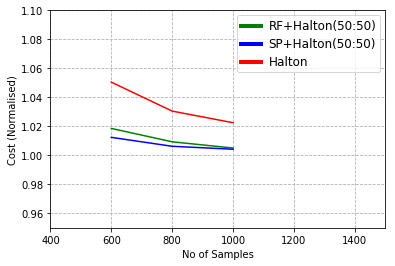

In [182]:
import matplotlib.pyplot as plt

print("RF = ", RF_length)
print("SP = ", SP_length)
print("Halton = ", Halton_length)

# fig1 = plt.figure(figsize=(10,6), dpi=80)
# ax1 = fig1.add_subplot(111, aspect='equal')


plt.plot(num_samples, RF_length, color = "green", label = "RF+Halton(50:50)")
plt.plot(num_samples, SP_length, color = "blue", label = "SP+Halton(50:50)")
plt.plot(num_samples, Halton_length, color = "red", label = "Halton")
# plt.plot(num_samples, np.ones(len(num_samples)), '--',color = "black", )

leg = plt.legend()
leg_lines = leg.get_lines()
leg_texts = leg.get_texts()
plt.setp(leg_lines, linewidth=4)
plt.setp(leg_texts, fontsize='large')
plt.xlim(400, 1500)
plt.ylim(0.95, 1.1)

csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}

plt.xlabel("No of Samples", **hfont)
plt.ylabel("Cost (Normalised)", **hfont)
plt.grid(True, linestyle = 'dashed')
plt.show()